# CDK2 protein
# Data load and preprocessing

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [49]:
%run ./1_Helper_functions.ipynb

In [50]:
protein_name='cdk2'
file_name = '../6_Machine_Learning_Models/df_DkSc_results_COCRYS_CSAR_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values

R_a = round(y.sum() / len(y), 2)
print('Ra =', R_a)

Ra = 0.12


## Estimators
### ML Classifiers

In [ ]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified", "random_state": 42}
dclf = DummyClassifier(**hyparams)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

hyparams ={'n_neighbors': 1, 'n_jobs': 4}
knn = KNeighborsClassifier(**hyparams)

In [5]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [6]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 20, 'learning_rate': 0.05, 
           'gamma': 0.01, 'colsample_bytree': 0.5, 'alpha': 0.01}
xgb = XGBClassifier(**hyparams)

In [7]:
# ML Classifier
ml_classifiers = {
    'knn': knn,
    'lr': lr,
    'xgb': xgb,
    'clf': clf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [8]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
    'VOTE': get_vote_score
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [9]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [10]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_02 = {'metric_name': 'ef', 
                    'fraction': 0.02, 'method':'normalized'},
             nef_12_Ra = {'metric_name': 'ef', 
                    'fraction': 0.12, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# Hold-out Validation 

### 30 replicas


In [11]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def n_hold_out_validation_SAVE(filename, **kwargs):
    return n_hold_out_validation(**kwargs)

In [12]:
%%time
evaluation_name='ho30'
ho30 = n_hold_out_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_reps=30, random_state=42)

full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMAX', 'csMEAN', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*ho30.columns],
    full_names))

ho30 = ho30.rename(columns=new_names)

File loaded: ./cachedir/ho30_cdk2
CPU times: user 110 µs, sys: 3.39 ms, total: 3.5 ms
Wall time: 3.1 ms


In [13]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

## AUC-ROC

In [45]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

,1-NN,Log. Reg.,XGB,csMAX,csMEAN,csMIN,csVOTE
Normality,1,1,1,1,1,1,1


,statistic,p
Bartlett,37.588723,0.000001


,chi^2,dof,p_value
Friedman Test,167.828571,6,1.298615e-33


In [46]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

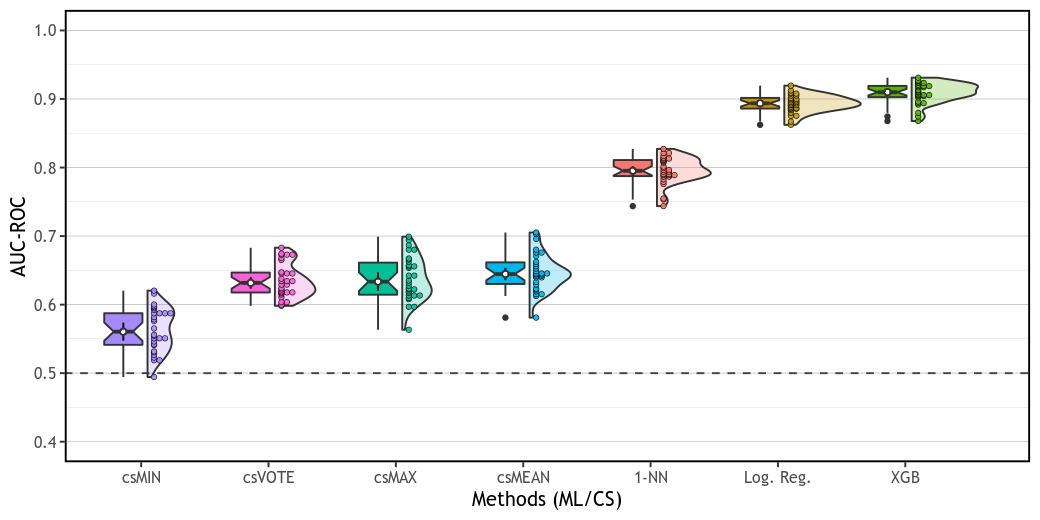

In [47]:
%%R -i full_names -i df_R -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.4, y_max=1.)

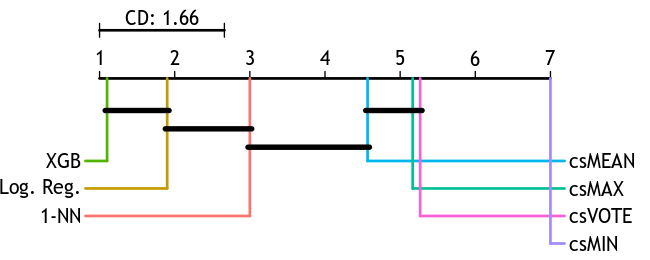

In [17]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths




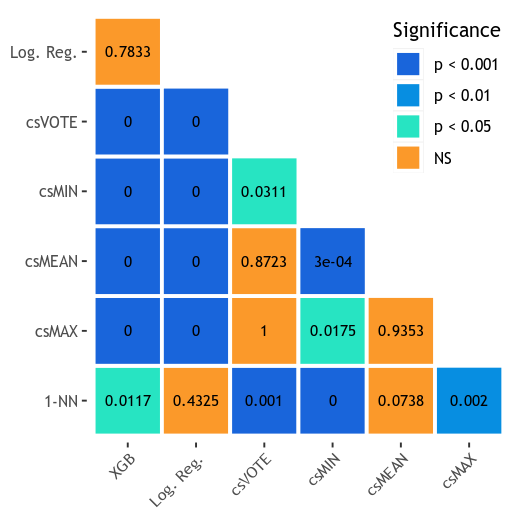

In [18]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 2%


In [19]:
# ROC-AUC
metric_name='nef_02'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

,1-NN,Log. Reg.,XGB,csMAX,csMEAN,csMIN,csVOTE
Normality,1,0,0,1,1,1,0


,statistic,p
Bartlett,25.19378,0.000314


,chi^2,dof,p_value
Friedman Test,142.678571,6,2.726109e-28


In [20]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



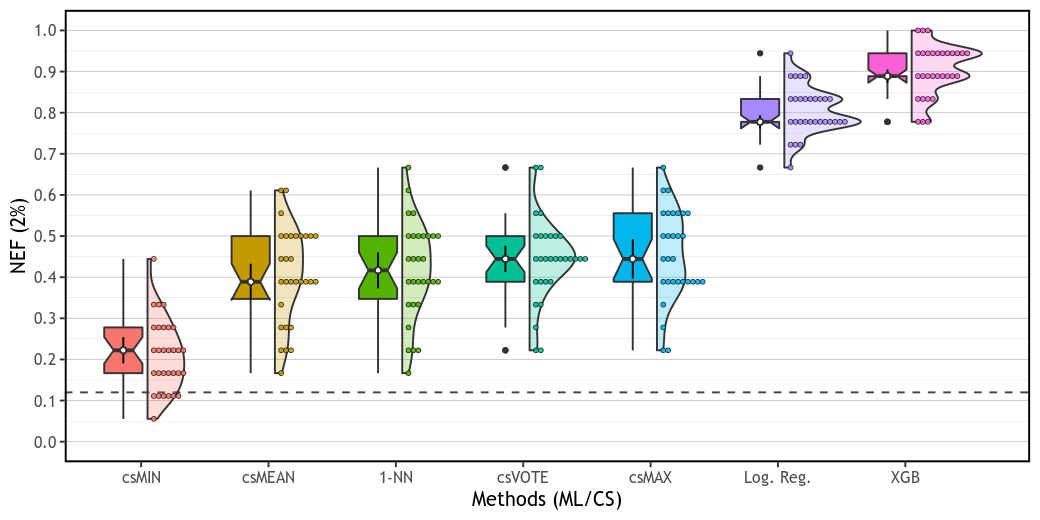

In [21]:
%%R -i df_Rmelted -i df_R -i full_names -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (2%)', dot_size=12, bin_width=0.001, base_h_line=R_a)

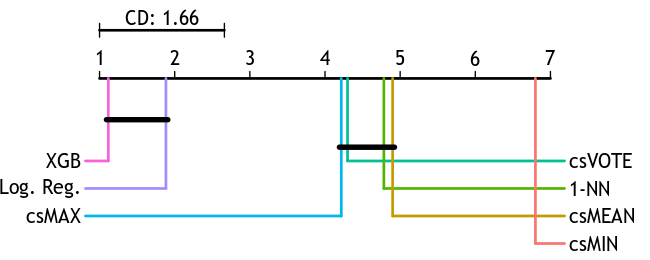

In [22]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

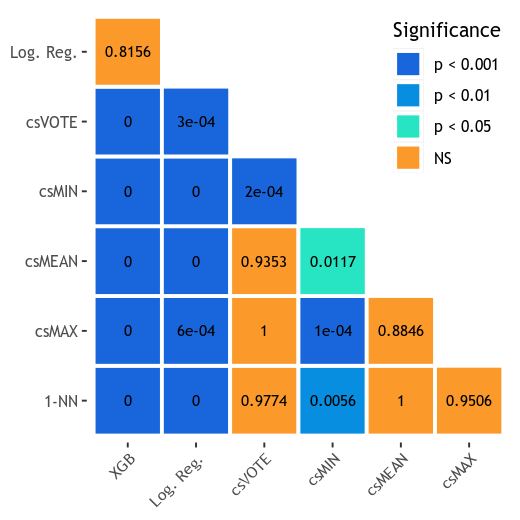

In [23]:
%%R -i df_R  -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

## EF 12% = Ra

In [24]:
# ROC-AUC
metric_name='nef_12_Ra'

# Normality
display(multi_norm_test(ho30, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(ho30, metric=metric_name))

friedmanTest(ho30.loc[metric_name])

,1-NN,Log. Reg.,XGB,csMAX,csMEAN,csMIN,csVOTE
Normality,0,1,1,1,1,1,1


,statistic,p
Bartlett,3.927412,0.686499


,chi^2,dof,p_value
Friedman Test,172.407143,6,1.387907e-34


In [25]:
df_R = order_df(ho30, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

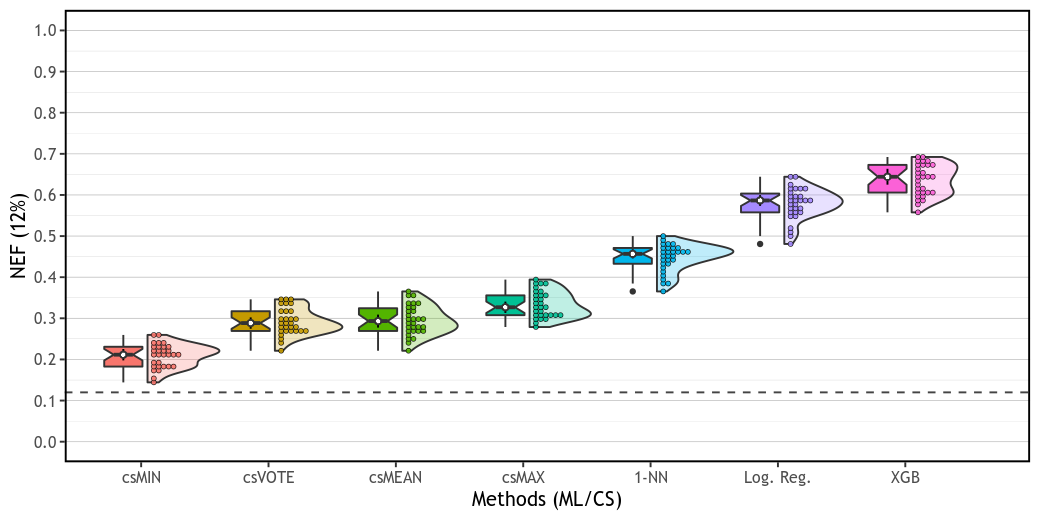

In [26]:
%%R -i df_Rmelted -i df_R -i full_names -w 8 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1.0, 
               y_label='NEF (12% = Ra)', dot_size=12, bin_width=0.001, base_h_line=R_a)

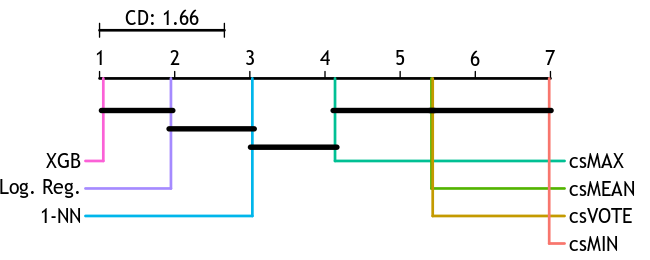

In [27]:
%%R -i df_R  -w 5 -h 2 --units in -r 130
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

par(family = "Trebuchet MS")
plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

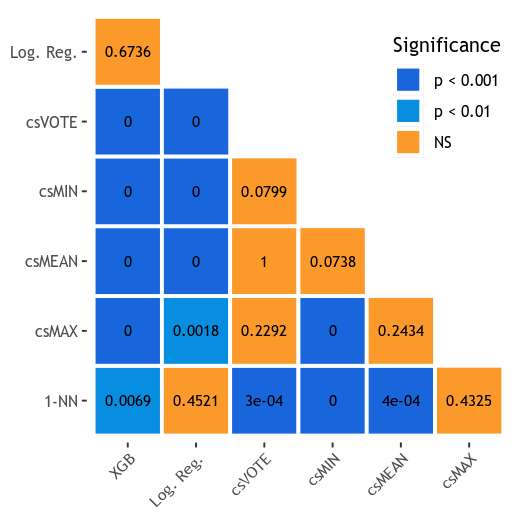

In [28]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

plot_p_vals_heatmap(df_R)

# Y-randomization test

In [29]:
@run_or_load_joblib
def n_hout_val_scrambling(filename, y, random_chi,  **kwargs):
    y_rand = randomize_y_labels(y_target=y, random_chi=random_chi)
    results = n_hold_out_validation(y=y_rand, **kwargs)
    return results

In [30]:
%%time
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
n_reps=30
chi_results = {}
evaluation_name = f'y_scrambling_{n_reps}_reps'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = n_hout_val_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_reps=n_reps, random_state=42)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result
    

File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_30_reps_cdk2_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 20.5 ms, sys: 49 µs, total: 20.6 ms
Wall time: 18.9 ms


## AUC-ROC

In [31]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)

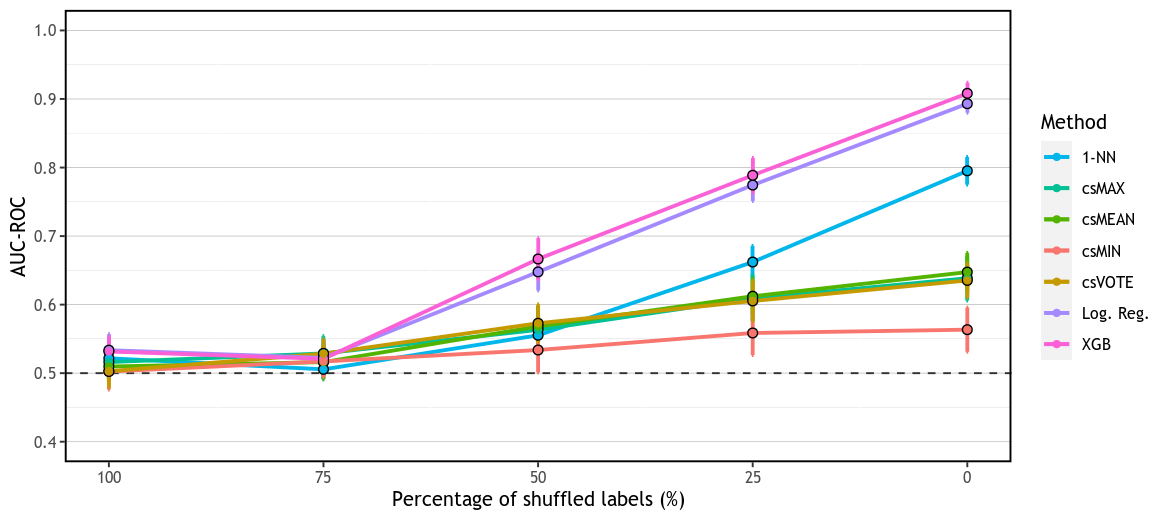

In [32]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette)

## EF 2% 

In [33]:
df_y_random = get_group_stats(chi_results, metric_name='nef_02')
df_y_random = df_y_random.replace(new_names)

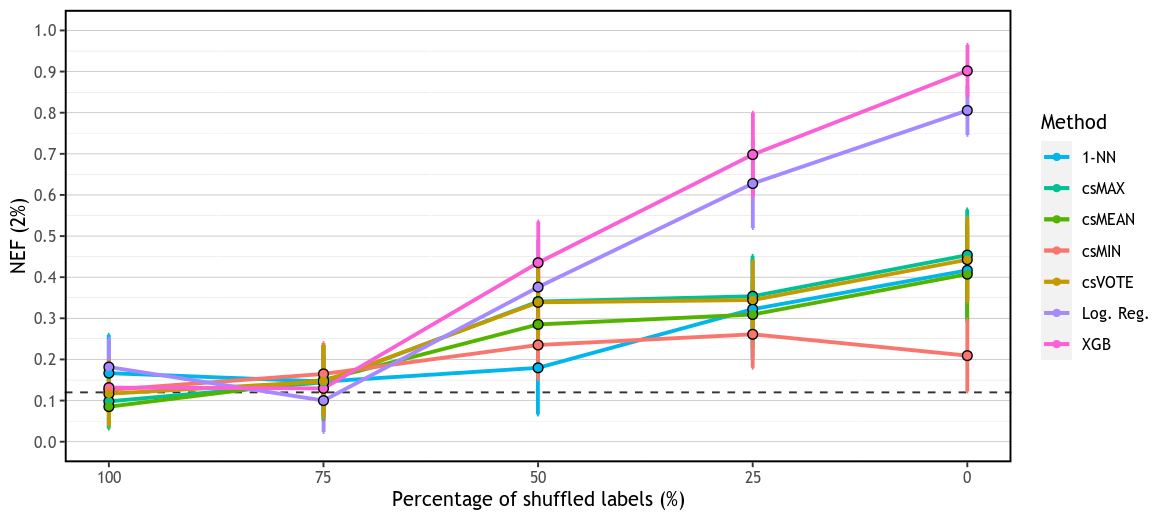

In [34]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, base_h_line=0.12, y_label='NEF (2%)')

## EF 12% 

In [35]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)

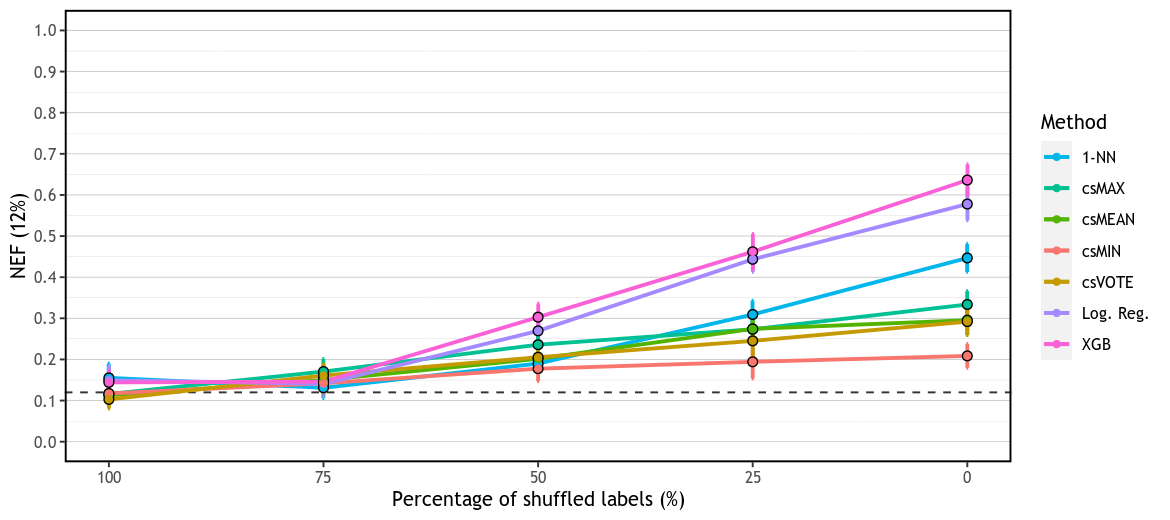

In [36]:
%%R -i df_y_random -i df_R -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

plot_lines(df_y_random, cbbPalette, y_min=0, y_max=1, base_h_line=0.12, y_label='NEF (12%)')

In [52]:
-np.log10(1/111)

2.0453229787866576